In [1]:
%%HTML
<style>
h2 {
    --background: #20BEFFBB;
    --foreground: blue;
    background-color: var(--background);
    border: 2px solid var(--foreground);
    padding: 20px;
    border-radius: 10px;
    color: var(--foreground);
}
h3 {
    --background: #FFCE84;
    --foreground: #F07108;
    background-color: var(--background);
    border: 2px solid var(--foreground);
    padding: 10px;
    border-radius: 10px;
    color: var(--foreground);
    width: 50%;
}
</style>

## Importing Libraries

In [2]:
# --- --- --- TORCH --- --- --- --- --- --- --- --- ---
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch import optim
from torch.autograd import Variable

# --- --- --- TORCH-VISION --- --- --- --- --- --- ---
from torchvision.transforms import transforms
from torchvision.models.vgg import vgg16
import torchvision.utils as utils

# --- --- DATA PRE-PROCESSING AND VISUALIZATION --- ---
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# --- --- PYTHON UTILITY LIBRARIES --- --- --- --- ---
from math import exp
import math
import warnings
from os.path import join
import os
from os import listdir
import gc
import shutil
from zipfile import ZipFile
warnings.filterwarnings("ignore")

In [3]:
# TO SUPPORT GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
# HYPER PARAMATERS
UPSCALE_FACTOR = 8
CROP_SIZE = 88

True


## Utility Functions

In [74]:
def is_valid_image(file_name):
    return any(file_name.endswith(ext) for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

def calc_valid_crop_size(crop_size,upscale_factor):
    return crop_size - (crop_size % upscale_factor)

# DATA PRE PROCESSING 
def high_res_transform(crop_size):
    return transforms.Compose([transforms.RandomCrop(crop_size), transforms.ToTensor()])

def low_res_transform(crop_size, upscale_factor):
    return transforms.Compose([transforms.ToPILImage(), transforms.Resize(crop_size//upscale_factor, interpolation = Image.BICUBIC), transforms.ToTensor()])

In [ ]:
def gaussian(window_size, sigma):
    g = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return g / g.sum()


def create_window(window_size, channel):
    dim1_window = gaussian(window_size, 1.5).unsqueeze(1)
    dim2_window = dim1_window.mm(dim1_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(dim2_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def structural_similarity_index_measure(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return structural_similarity_index_measure(img1, img2, window, window_size, channel, size_average)

### Train and Validation Data Loaders

In [70]:
# BASE_PATH = "/kaggle/input/objectdetectiondatasetcar/car"
# with ZipFile('./train_sample.zip', 'w') as zip_object:
#     for file_name in os.listdir(BASE_PATH)[:20]:
#         if is_valid_image(file_name):
#             zip_object.write(join(BASE_PATH, file_name))

In [82]:
# BASE_PATH = "/kaggle/input/objectdetectiondatasetcar/car"
# with ZipFile('./valid_sample.zip', 'w') as zip_object:
#     for file_name in os.listdir(BASE_PATH)[21:41]:
#         if is_valid_image(file_name):
#             zip_object.write(join(BASE_PATH, file_name))

In [83]:
class TrainDataFromFolder(Dataset):
    def __init__(self,file_names, crop_size, upscale_factor):
        super().__init__()
        self.image_file_names = file_names
        crop_size = calc_valid_crop_size(crop_size, upscale_factor)
        self.high_res_transform = high_res_transform(crop_size)
        self.low_res_transform = low_res_transform(crop_size,upscale_factor)

    def __getitem__(self,index):
        hr_image = self.high_res_transform(Image.open(self.image_file_names[index]))
        lr_image = self.low_res_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_file_names)

In [84]:
class ValDataFromFolder(Dataset):
    def __init__(self,file_names, upscale_factor):
        super().__init__()
        self.upscale_factor = upscale_factor
        self.image_file_names = file_names

    def __getitem__(self,index):
        hr_image = Image.open(self.image_file_names[index])
        w,h = hr_image.size
        crop_size = calc_valid_crop_size(min(w,h), self.upscale_factor)
        lr_scale = transforms.Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        hr_scale = transforms.Resize(crop_size, interpolation=Image.BICUBIC)
        hr_image = transforms.CenterCrop(crop_size)(hr_image)
        lr_image = lr_scale(hr_image)
        hr_restored_image = hr_scale(lr_image)
        # LR, SR, HR
        return transforms.ToTensor()(lr_image), transforms.ToTensor()(hr_restored_image), transforms.ToTensor()(hr_image)

    def __len__(self):
        return len(self.image_file_names)
    

In [85]:
TRAFFIC_TRAIN_DIR = "/kaggle/input/objectdetectiondatasetcar/car"

In [86]:
def get_train_valid_data(data_dir=TRAFFIC_TRAIN_DIR,train_frac=0.8):
    file_names = [join(data_dir,x) for x in listdir(data_dir) if is_valid_image(x)]
    assert train_frac < 1
    train_set = TrainDataFromFolder(file_names =file_names[:int(len(file_names) * train_frac)] ,crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
    val_set = ValDataFromFolder(file_names =file_names[int(len(file_names) * train_frac):], upscale_factor=UPSCALE_FACTOR)
    train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=16, shuffle=True)
    val_loader = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)
    return train_loader, val_loader

In [87]:
train_loader, val_loader = get_train_valid_data()

In [15]:
# del train_set
# del val_set
# del train_loader
# del val_loader

## Neural Networks Blocks

__Building SRGAN Model Architecture as a Base Model__

![SRGAN](https://raw.githubusercontent.com/tensorlayer/srgan/master/img/model.jpeg)

### 1. Residual Block

In [16]:
# RESIDUAL BLOCK
"""CONSISTING OF :
1. CONVOLUTIONAL LAYER (Kernels=64, Strid=1)
2. BATCH NORMALIZATION 
3. ReLU
4. CONVOLUTIONAL LAYER (Kernels=64, Strid=1)
5. BATCH NORMALIZATION 
6. ELEMENT WISE SUM
"""
class ResidualBlock(nn.Module):
    
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        x_temp = self.conv1(x)
        x_temp = self.bn1(x_temp)
        x_temp = self.prelu(x_temp)
        x_temp = self.conv2(x_temp)
        x_temp = self.bn2(x_temp)
        return x + x_temp

### 2. Up Sampling Block

In [17]:
class UpsampleBlock(nn.Module):
    
    def __init__(self, in_ch, up_scale_factor):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_ch, in_ch * up_scale_factor ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale_factor)
        self.prelu = nn.PReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

### A. Generator

In [18]:
class Generator(nn.Module):
    
    def __init__(self, scale_factor):
        super(Generator, self).__init__()
        num_upsample_block = int(math.log(scale_factor, 2))

        self.b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=9, padding=4),nn.PReLU())
        self.b2 = ResidualBlock(64)
        self.b3 = ResidualBlock(64)
        self.b4 = ResidualBlock(64)
        self.b5 = ResidualBlock(64)
        self.b6 = ResidualBlock(64)
        self.b7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        temp_b8 = [UpsampleBlock(64, 2) for i in range(num_upsample_block)] + [nn.Conv2d(64, 3, kernel_size=9, padding=4)]
        self.b8 = nn.Sequential(*temp_b8)
        
    def forward(self, x):
        x1 = self.b1(x)
        x2 = self.b2(x1)
        x3 = self.b3(x2)
        x4 = self.b4(x3)
        x5 = self.b5(x4)
        x6 = self.b6(x5)
        x7 = self.b7(x6)
        x8 = self.b8(x1 + x7)
        return (torch.tanh(x8) + 1) / 2


### B. Discriminator

In [19]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )
        
    def forward(self, x):
        batch_size=x.size()[0]
        return torch.sigmoid(self.net(x).view(batch_size))
     

## Loss Functions

In [20]:
# Total Variation Loss
class TVLoss(nn.Module):
    
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight
        
    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]

        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])

        h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
        w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size
  
    @staticmethod 
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [13]:
vgg16_model = vgg16(pretrained=True)
vgg16_model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [21]:
class GeneratorLoss(nn.Module):
    
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        # ------------------- VGG LOSS -----------------------------
        vgg = vgg16(pretrained=True)
        # GETTING THE FEATURE EXTRACTING LAYERS
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        # DISABLING THE TRAINING OF THE LAYERS
        for p in loss_network.parameters():
            p.requires_grad = False
        self.loss_network = loss_network
        
        # ------------------ MSE LOSS ------------------------------
        self.mse_loss = nn.MSELoss()
        
        # ----------------- TV LOSS --------------------------------
        self.tv_loss = TVLoss()
        
    def forward(self, out_labels, out_images, target_images):
        # COMBINING 4 DIFFERENT LOSSES
        
        # 1. DISCRIMINATOR LOSS
        adversial_loss = torch.mean(1 - out_labels)
        
        # 2. PERSEPTUAL LOSS (VGG16)
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        
        # 3. MSE LOSS
        image_loss = self.mse_loss(out_images, target_images)
        
        # 4. TV LOSS
        tv_loss = self.tv_loss(out_images)
        
        return image_loss + (0.002 * adversial_loss) + (0.005 * perception_loss) + (2e-8 * tv_loss)

## Initializing discriminator and generator

In [22]:
model_G = Generator(UPSCALE_FACTOR)
model_D = Discriminator()
generator_loss = GeneratorLoss()

# To Support GPU
generator_loss = generator_loss.to(DEVICE)
model_G = model_G.to(DEVICE)
model_D = model_D.to(DEVICE)

# OPTIMIZERS
optim_G = optim.Adam(model_G.parameters(), lr=0.0002)
optim_D = optim.Adam(model_D.parameters(), lr=0.0002)

## Training

In [41]:
# ------------------------- CLEAR GPU RAM --------------------------------
# del model
# del train_loader
# del val_loader
torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.memory_summary(device=None, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    3475 KB |   15411 MB |   18529 MB |   18526 MB |
|---------------------------------------------------------------------------|
| Active memory         |    3475 KB |   15411 MB |   18529 MB |   18526 MB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    4096 KB |   15490 MB |   15492 MB |   15488 MB |
|---------------------------------------------------------------

In [91]:
# for i,j in train_loader:
#     print(i.shape)
#     print(j.shape)
#     break

torch.Size([16, 3, 11, 11])
torch.Size([16, 3, 88, 88])


In [34]:
# --------------------------- ACTUAL MODEL TRAINING ---------------------------------
NUM_EPOCHS = 10
RESULTS = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}
for epoch in range(1, NUM_EPOCHS + 1):
        train_bar = tqdm(train_loader)
        history = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}
        
        # SETTING THE MODELS TO TRAIN MODE
        model_G.train()
        model_D.train()
        #---------------------------------- TRAINING ---------------------------------
        for lr_image_set, hr_image_set in train_bar:
            batch_size = lr_image_set.size(0)
            history['batch_sizes'] += batch_size
            
            # --- --- --- --- LOADING DATA --- --- --- ---
            real_img = Variable(hr_image_set)
            lr_image_set = Variable(lr_image_set)
            if torch.cuda.is_available():
                real_img = real_img.cuda()
                lr_image_set = lr_image_set.cuda()
            
            # DISCRIMINATOR TRAINING STEP -------------------------
            fake_img = model_G(lr_image_set) # FORWARD PROPAGATION IN GENERATOR
            model_D.zero_grad()
            real_out = model_D(real_img).mean()
            fake_out = model_D(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True) # BACKWARD PROPAGATION OF DISCRIMINATOR
            optim_D.step()
    
            # GENERATOR TRAINING STEP ---------------------------
            model_G.zero_grad()        
            fake_img = model_G(lr_image_set)
            fake_out = model_D(fake_img).mean()
            g_loss = generator_loss(fake_out, fake_img, real_img)
            g_loss.backward() # BACKWARD PROPAGATION OF GENERATOR
            fake_img = model_G(lr_image_set)
            fake_out = model_D(fake_img).mean()
            optim_G.step()

            # --- --- --- --- --- --- UPDATING PROGRESS BAR --- --- --- --- --- ---
            history['g_loss'] += g_loss.item() * batch_size
            history['d_loss'] += d_loss.item() * batch_size
            history['d_score'] += real_out.item() * batch_size
            history['g_score'] += fake_out.item() * batch_size
            train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
                epoch, NUM_EPOCHS, history['d_loss'] / history['batch_sizes'],
                history['g_loss'] / history['batch_sizes'],
                history['d_score'] / history['batch_sizes'],
                history['g_score'] / history['batch_sizes']))
        
        # SETTING THE MODELS TO EVAL MODE (NON TRAINING MODE)
        model_G.eval()
        
        # ---------------------------------- VALIDATION ---------------------------------------
        with torch.no_grad():
            val_bar = tqdm(val_loader)
            valid_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            val_images = []
            for val_lr, val_hr_restore, val_hr in val_bar:
                batch_size = val_lr.size(0)
                valid_results['batch_sizes'] += batch_size
                lr = val_lr
                hr = val_hr
                if torch.cuda.is_available():
                    lr = lr.cuda()
                    hr = hr.cuda()
                sr = model_G(lr)
        
                batch_mse = ((sr - hr) ** 2).data.mean()
                valid_results['mse'] += batch_mse * batch_size
                batch_ssim = ssim(sr, hr).item()
                valid_results['ssims'] += batch_ssim * batch_size
                valid_results['psnr'] = 10 * math.log10((hr.max()**2) / (valid_results['mse'] / valid_results['batch_sizes']))
                valid_results['ssim'] = valid_results['ssims'] / valid_results['batch_sizes']
                val_bar.set_description(
                    desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                        valid_results['psnr'], valid_results['ssim']))
        
        if not os.path.exists('epochs/'):
            os.makedirs('epochs/')
        

        # ------------------------ APPEND EPOCH METRICS -------------------------------------
        RESULTS['d_loss'].append(history['d_loss'] / history['batch_sizes'])
        RESULTS['g_loss'].append(history['g_loss'] / history['batch_sizes'])
        RESULTS['d_score'].append(history['d_score'] / history['batch_sizes'])
        RESULTS['g_score'].append(history['g_score'] / history['batch_sizes'])
        RESULTS['psnr'].append(valid_results['psnr'])
        RESULTS['ssim'].append(valid_results['ssim'])
        
        
        #------------------------------------------------------------------------------------
        if epoch == NUM_EPOCHS:
            # <-------------------- SAVING MODELS -------------------->
            torch.save(model_G.state_dict(), f'epochs/model_G_{UPSCALE_FACTOR}.pth')
            torch.save(model_D.state_dict(), f'epochs/model_D_{UPSCALE_FACTOR}.pth')
            
            # <------------------- SAVING STATISTICS ----------------->
            OUT_DIR = 'statistics/'
            if not os.path.exists(OUT_DIR):
                os.makedirs(OUT_DIR)
            data_frame = pd.DataFrame(
                data={
                    'Loss_D': RESULTS['d_loss'], 
                    'Loss_G': RESULTS['g_loss'], 
                    'Score_D': RESULTS['d_score'],
                    'Score_G': RESULTS['g_score'], 
                    'PSNR': RESULTS['psnr'], 
                    'SSIM': RESULTS['ssim']
                },
                index=range(1, epoch + 1)
            )
            data_frame.to_csv(OUT_DIR + f'train_history.csv', index_label='Epoch')

[1/10] Loss_D: 0.0153 Loss_G: 0.0119 D(x): 0.9897 D(G(z)): 0.0048: 100%|██████████| 23/23 [00:05<00:00,  4.02it/s]
[converting LR images to SR images] PSNR: 20.6632 dB SSIM: 0.6756: 100%|██████████| 91/91 [00:06<00:00, 13.23it/s]
[2/10] Loss_D: 0.1933 Loss_G: 0.0125 D(x): 0.8767 D(G(z)): 0.0460: 100%|██████████| 23/23 [00:05<00:00,  4.12it/s]
[converting LR images to SR images] PSNR: 21.4600 dB SSIM: 0.6802: 100%|██████████| 91/91 [00:06<00:00, 13.53it/s]
[3/10] Loss_D: 0.1183 Loss_G: 0.0126 D(x): 0.9239 D(G(z)): 0.0199: 100%|██████████| 23/23 [00:05<00:00,  4.02it/s]
[converting LR images to SR images] PSNR: 21.0818 dB SSIM: 0.6715: 100%|██████████| 91/91 [00:06<00:00, 13.61it/s]
[4/10] Loss_D: 0.8507 Loss_G: 0.0109 D(x): 0.6893 D(G(z)): 0.5284: 100%|██████████| 23/23 [00:05<00:00,  3.96it/s]
[converting LR images to SR images] PSNR: 21.2151 dB SSIM: 0.6724: 100%|██████████| 91/91 [00:06<00:00, 13.27it/s]
[5/10] Loss_D: 0.9142 Loss_G: 0.0109 D(x): 0.5987 D(G(z)): 0.4986: 100%|████████

## Model Evaluation

In [92]:
# LOAD MODEL
model = Generator(UPSCALE_FACTOR).eval()
model.load_state_dict(torch.load("/kaggle/working/epochs/model_G_8.pth"))
model = model.to(DEVICE)

In [45]:
def _low_res_transform(crop_size,UPSCALE_FACTOR):
    return transforms.Compose([transforms.ToPILImage(), transforms.Resize(50, interpolation = Image.BICUBIC), transforms.ToTensor()])

In [46]:
image_name= "/kaggle/input/objectdetectiondatasetcar/car/0.png"
image_hr = Image.open(image_name)
image_hr = transforms.ToTensor()(image_hr).unsqueeze(0)
image_lr = _low_res_transform(CROP_SIZE,UPSCALE_FACTOR)(image_hr[0])[None,:]

In [ ]:
image_out = model(image_lr.to(DEVICE))

## Results Visualization

The model will upscale the resolution of image of any dimensions by a factor of 8

### High Resolution (Original Image)

torch.Size([1, 3, 1080, 1920])


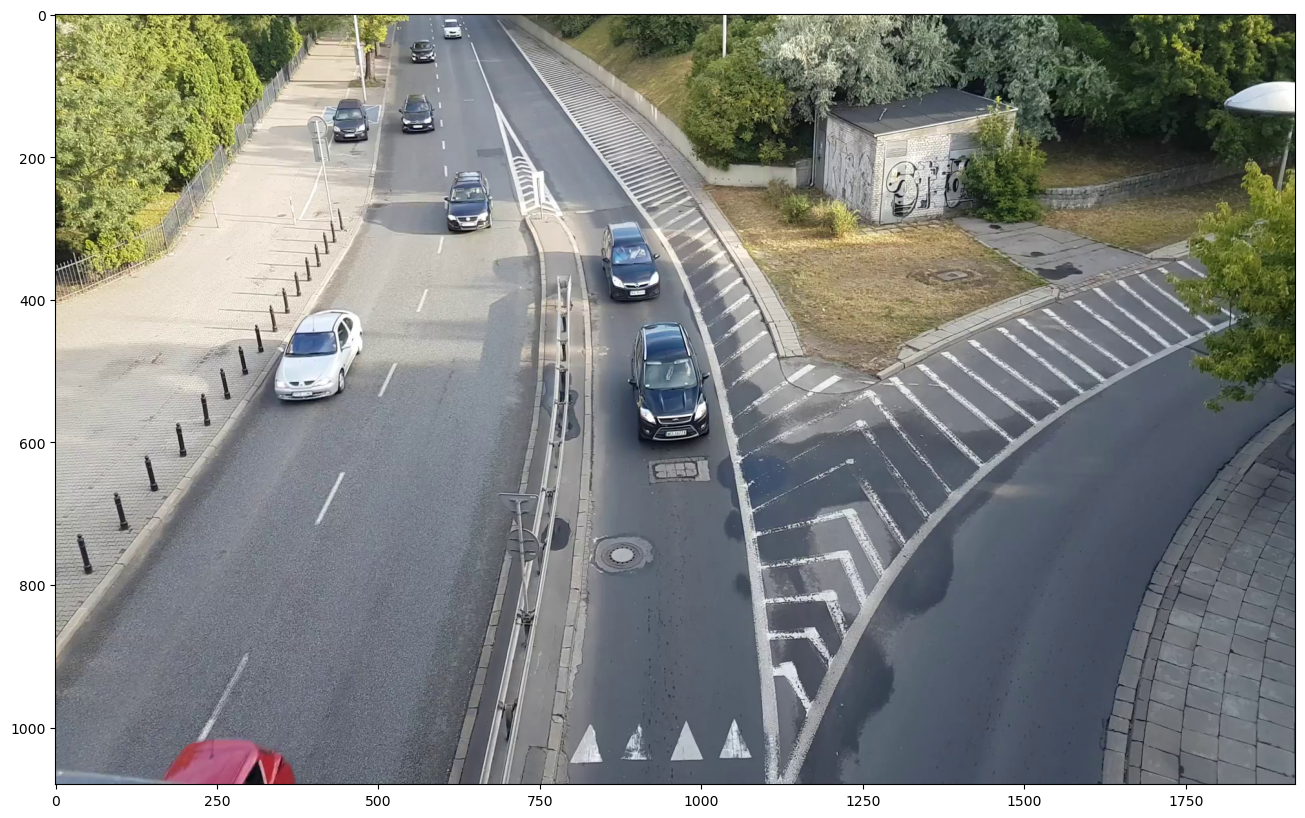

In [48]:
# HR
print(image_hr.shape)
temp_image_hr = image_hr[0].permute(1, 2, 0)
plt.figure(figsize=(16,10))
plt.imshow(temp_image_hr,aspect="auto")
plt.show()

### Low Resolution (Down Sampled)

torch.Size([1, 3, 50, 88])


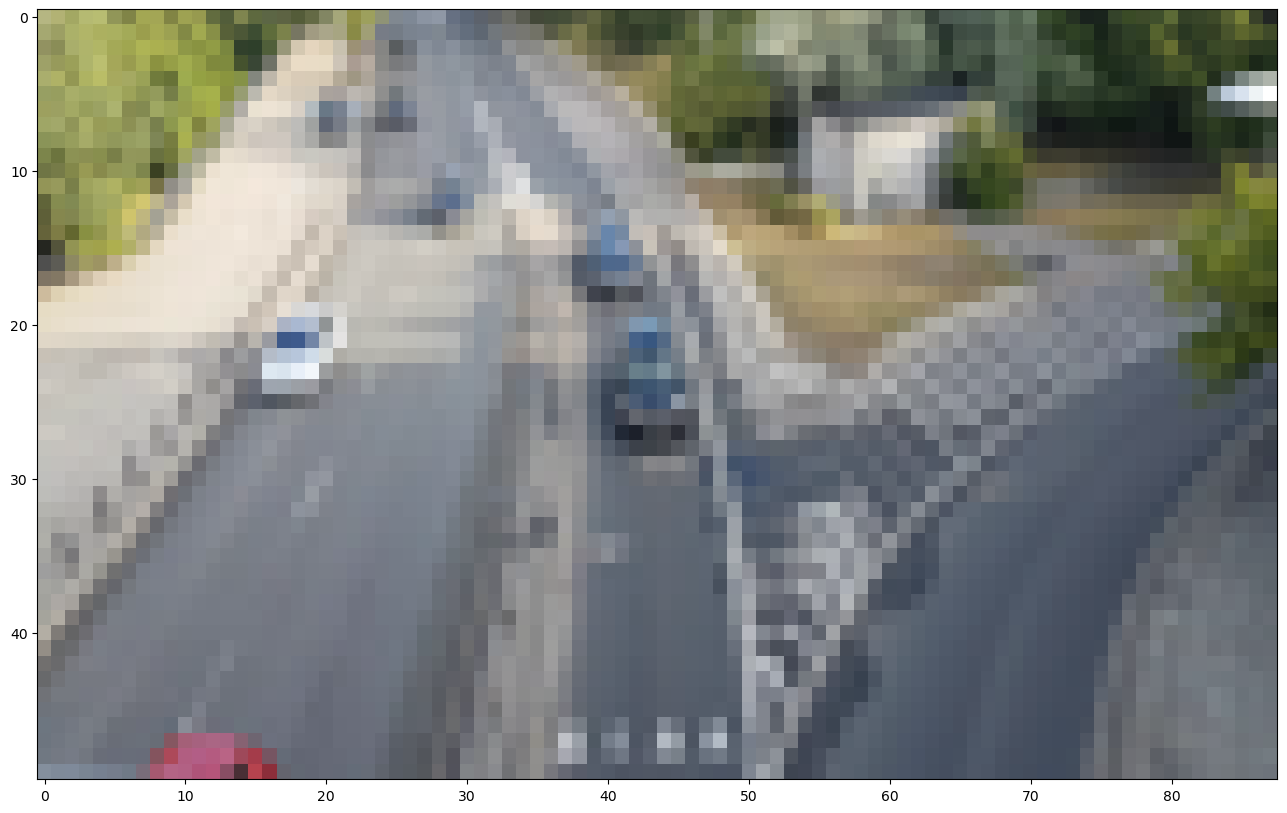

In [49]:
# LR
print(image_lr.shape)
temp_image_lr = image_lr[0].permute(1, 2, 0)
plt.figure(figsize=(16,10))
plt.imshow(temp_image_lr,aspect="auto")
plt.show()

### Super Resolution (Output)

torch.Size([1, 3, 400, 704])


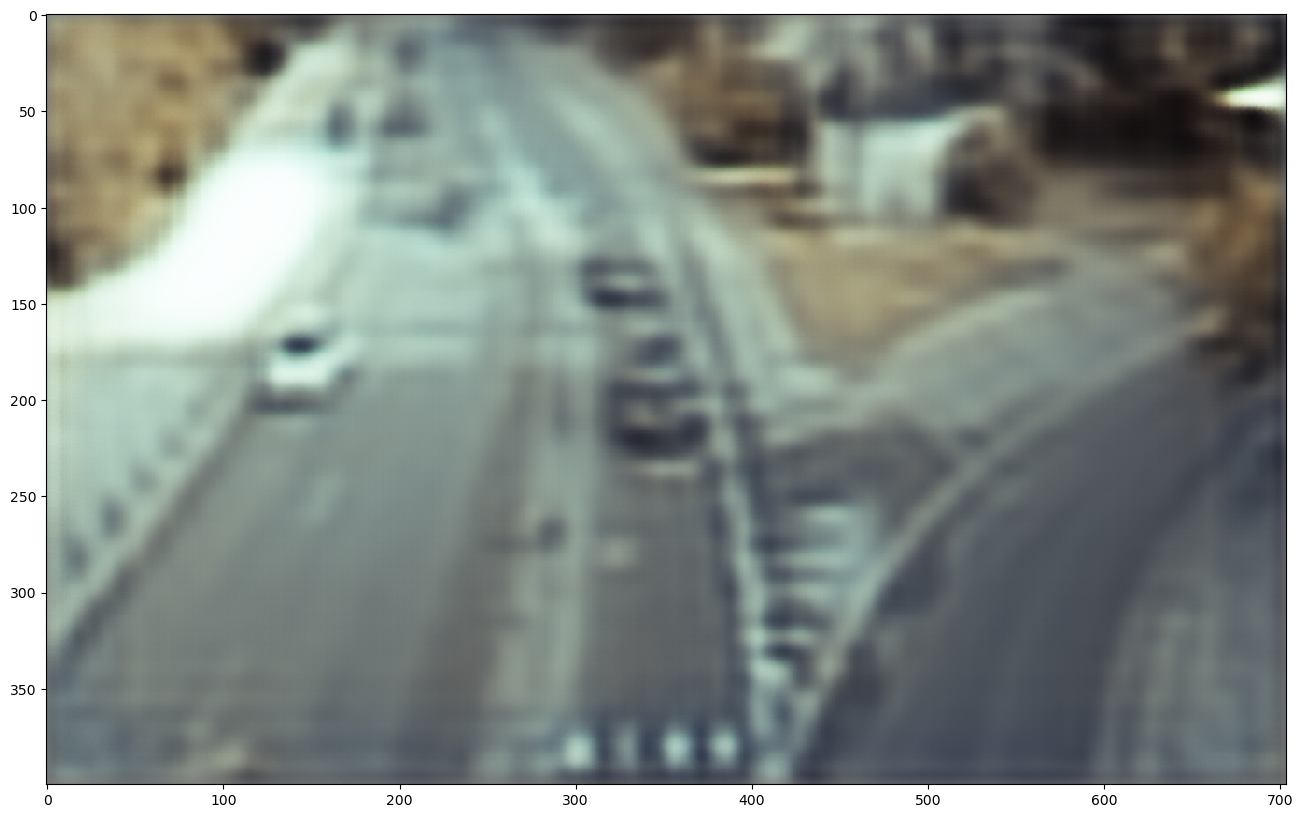

In [62]:
# SR
print(image_out.shape)
temp_image_out = image_out[0].permute(1, 2, 0)
image_display = transforms.ToPILImage()(image_out[0].data.cpu())
plt.figure(figsize=(16,10))
plt.imshow(image_display,aspect="auto")
plt.show()

In [51]:
transforms.ToPILImage()(image_out[0].data.cpu()).save("out.jpeg")
transforms.ToPILImage()(image_lr[0].data.cpu()).save("in.jpeg")

In [54]:
history = pd.read_csv("/kaggle/working/statistics/srf_8_train_results.csv")

<AxesSubplot:>

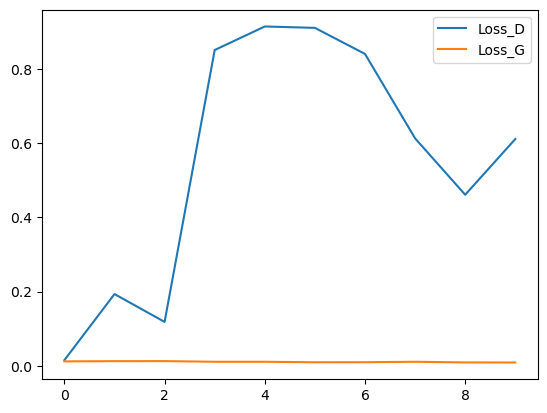

In [61]:
history[["Loss_D","Loss_G"]].plot()

<AxesSubplot:>

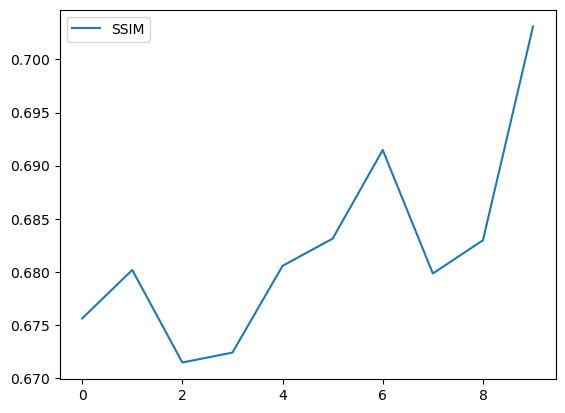

In [64]:
history[["SSIM"]].plot()

<AxesSubplot:>

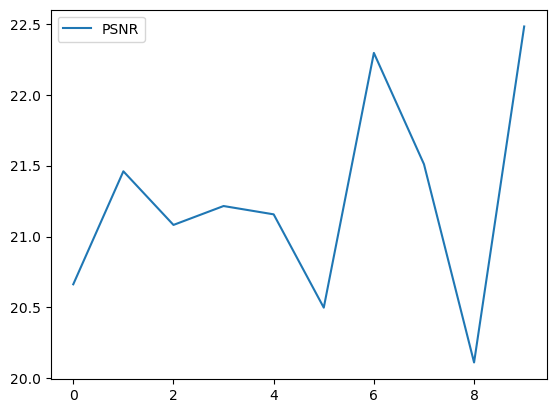

In [65]:
history[["PSNR"]].plot()

## END